# Work Package 1 and 3 visualization notebook

In [2]:
# !pip install pygrib matplotlib cartopy

In [1]:
%reload_ext autoreload
%autoreload 2

## Set the project's path

In [2]:
import sys, os

ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add dir2 to the Python path
sys.path.append(ROOT_PATH)

## Import the grib files' path and create the file lists

In [3]:
from grib_files import grib_files_paths, grib_pert_cfgs

In [4]:
orig_files_paths = dict()
orig_files_preds_paths = dict()
pert_files_paths = dict()

for _file in grib_files_paths:
    filedate = _file.split("_")[0]
    if "orig_init" in _file:
        if "pred" in _file:
            d_orig = orig_files_preds_paths.get(filedate, dict())
            d_orig[_file] = grib_files_paths[_file]
            orig_files_preds_paths[filedate] = d_orig
        else: 
            d_orig = orig_files_paths.get(filedate, dict())
            d_orig[_file] = grib_files_paths[_file]
            orig_files_paths[filedate] = d_orig
    elif "pert" in _file and "240h" in _file:
        d_pert = pert_files_paths.get(filedate, dict())
        d_pert[_file] = grib_files_paths[_file]
        pert_files_paths[filedate] = d_pert


## Select init date, considering the exiting files in grib_files/experiments_grib_files

In [5]:
import ipywidgets as widgets

w0 = widgets.Dropdown(
    options=orig_files_paths.keys(),
    value=list(orig_files_paths.keys())[0],
    description='Init date:',
    style={'description_width': 'initial'}
)

filedate = list(orig_files_paths.keys())[0]
grib_file = list(orig_files_paths[w0.value].values())[0]
grib_file_preds = list(orig_files_preds_paths[w0.value].values())[0]

def on_change0(change):
    global grib_file
    global grib_file_preds
    global filedate
    if change['type'] == 'change' and change['name'] == 'value':
        grib_file = list(orig_files_paths[w0.value].values())[0]
        grib_file_preds = list(pert_files_paths[w0.value].values())[0]
        filedate = w0.value

w0.observe(on_change0)

display(w0)


Dropdown(description='Init date:', options=('20240302', '20240531', '20240308'), style=DescriptionStyle(descri…

## Based on Init date, select Perturbation grib file

In [6]:
w1 = widgets.Dropdown(
    options=pert_files_paths[filedate].keys(),
    value=list(pert_files_paths[filedate].keys())[0],
    description='Perturbations grib file:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='30%')
)
grib_file_pert_preds = list(pert_files_paths[w0.value].values())[0]

def on_change1(change):
    global grib_file_pert
    global grib_file_pert_preds
    if change['type'] == 'change' and change['name'] == 'value':
        grib_file_pert_preds = pert_files_paths[filedate][w1.value]
        

w1.observe(on_change1)

display(w1)


Dropdown(description='Perturbations grib file:', layout=Layout(width='30%'), options=('20240302_pert_mode_PE_p…

## Set the variable, level and polygons (if the case) considering the perturbed file

In [7]:
# variable = 'msl'
# level = 0

variable = grib_pert_cfgs.get(f"{w1.value.split('_240h_pred')[0]}_cfg", {}).get('variable', '')
level = grib_pert_cfgs.get(f"{w1.value.split('_240h_pred')[0]}_cfg", {}).get('level', '')

default_perturb_polygon = [[0,0], [0,0], [0,0], [0,0], [0,0]]

lonw_list = grib_pert_cfgs.get(f"{w1.value}_cfg", {}).get('lonw_list', '')
lone_list = grib_pert_cfgs.get(f"{w1.value}_cfg", {}).get('lone_list', '')
lats_list = grib_pert_cfgs.get(f"{w1.value}_cfg", {}).get('lats_list', '')
latn_list = grib_pert_cfgs.get(f"{w1.value}_cfg", {}).get('latn_list', '')
lat_min = grib_pert_cfgs.get(f"{w1.value}_cfg", {}).get('lat_min', '')
lat_max = grib_pert_cfgs.get(f"{w1.value}_cfg", {}).get('lat_max', '')
lon_min = grib_pert_cfgs.get(f"{w1.value}_cfg", {}).get('lon_min', '')
lon_max = grib_pert_cfgs.get(f"{w1.value}_cfg", {}).get('lon_max', '')

if all([lonw_list, lone_list, lats_list, latn_list]):
    polygons = []
    for i in range(len(lonw_list)):
        polygons.append(
            [
                [lonw_list[i], lats_list[i]],
                [lone_list[i], lats_list[i]],
                [lone_list[i], latn_list[i]],
                [lonw_list[i], latn_list[i]],
                [lonw_list[i], lats_list[i]],
            ]
        )
elif all([lat_min, lat_max, lon_min, lon_max]):
    polygons = [
        [lon_min, lat_min],
        [lon_max, lat_min],
        [lon_max, lat_max],
        [lon_min, lat_max],
        [lon_min, lat_min],
    ]
else:
    polygons = default_perturb_polygon


In [8]:
variable = 'msl'
level = 0

## Visualize the init file and the perturbation area (if local)

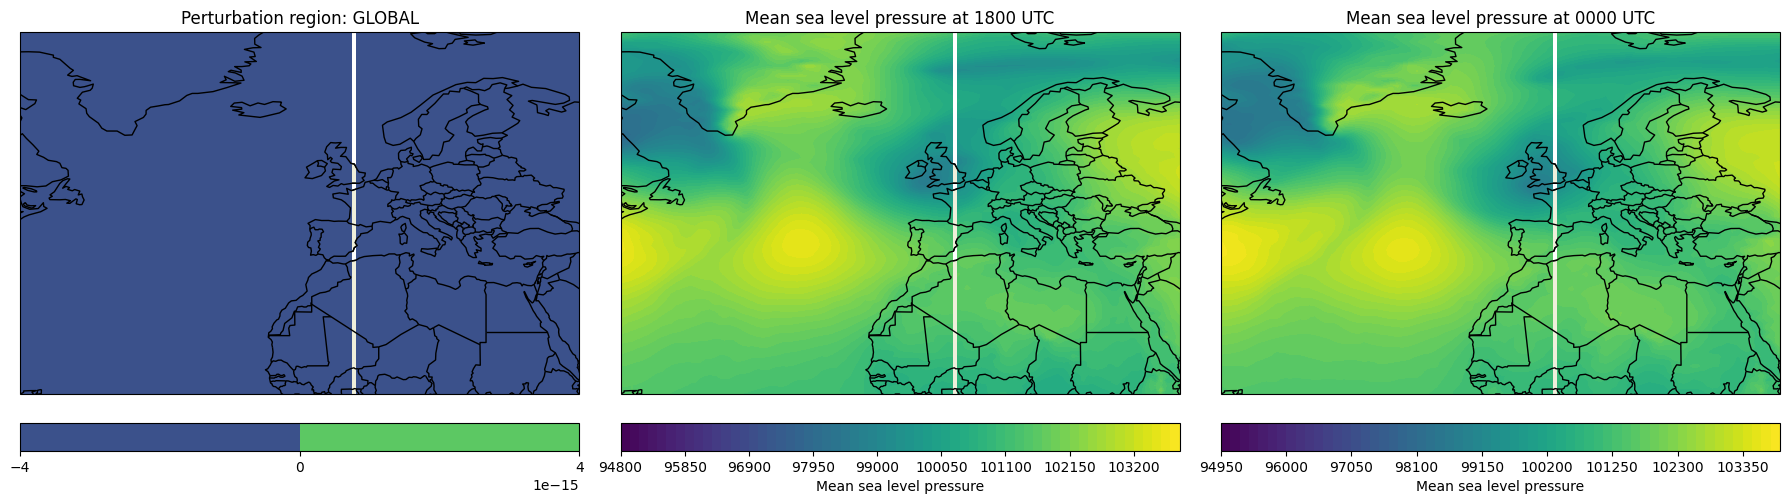

In [9]:
import pygrib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Polygon
import numpy as np

# set this to US East Coast, Atlantic and Europe
lonmin, lonmax = -65, 43
latmin, latmax = 10, 80

# Open the GRIB file
# grib_file = '/home/user/large-disk/aifs_grib_perturbations/grib_files/experiments_grib_files/20240302_orig_init.grb'
grbs = pygrib.open(grib_file)

# Function to create map and plot GRIB data
def plot_grib_data(ax, grb, title, polygons=[], visualization_polygon=[lonmin, lonmax, latmin, latmax]):
    data, lats, lons = grb.data()
    if polygons:
        if polygons[0] != default_perturb_polygon:
            for pol in polygons:
                cs = ax.contourf(lons, lats, np.zeros((192,384)), 60, transform=ccrs.PlateCarree(), cmap='viridis')
                ax.coastlines()
                ax.add_feature(cfeature.BORDERS)
                ax.add_feature(cfeature.LAND, edgecolor='black')
                cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, ax=ax)
                polygon = Polygon(pol, closed=True, edgecolor='red', facecolor='none', lw=2)
                ax.add_patch(polygon)
        else:
            cs = ax.contourf(lons, lats, np.zeros((192,384)), 60, transform=ccrs.PlateCarree(), cmap='viridis')
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS)
            ax.add_feature(cfeature.LAND, edgecolor='black')
            cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, ax=ax)
            title = f"{title}: GLOBAL"
    else:
        cs = ax.contourf(lons, lats, data, 60, transform=ccrs.PlateCarree(), cmap='viridis')
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND, edgecolor='black')
        cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, ax=ax)
        cbar.set_label(grb.parameterName)
        
    ax.set_title(title)
    ax.set_extent(visualization_polygon, crs=ccrs.PlateCarree())

# Create a single figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# 1. Plot the map and point out the polygons to be perturbed
ax1 = axes[0]
plot_grib_data(ax1, grbs[1], title='Perturbation region', polygons=[polygons])

# 2. Plot the GRIB variable at time 1800 on the second subplot
grb_1800 = None
for grb in grbs:
    if grb.validDate.hour == 18 and grb.validDate.minute == 0 and grb.shortName == variable and grb.level == level:
        grb_1800 = grb
        break

if grb_1800:
    ax2 = axes[1]
    if not level:
        plot_grib_data(ax2, grb_1800, f'{grb_1800.parameterName} at 1800 UTC')
    else:
        plot_grib_data(ax2, grb_1800, f'{grb_1800.parameterName} level {level} at 1800 UTC')
else:
    print("No data found for 1800 UTC.")

# 3. Plot the GRIB variable at time 0000 on the third subplot
grb_0000 = None
for grb in grbs:
    if grb.validDate.hour == 0 and grb.validDate.minute == 0 and grb.shortName == variable and grb.level == level:
        grb_0000 = grb
        break

if grb_0000:
    ax3 = axes[2]
    if not level:
        plot_grib_data(ax3, grb_0000, f'{grb_0000.parameterName} at 0000 UTC')
    else:
        plot_grib_data(ax3, grb_0000, f'{grb_0000.parameterName} level {level} at 0000 UTC')
else:
    print("No data found for 0000 UTC.")

# Close the GRIB file
grbs.close()

# Adjust layout
plt.tight_layout()

# Show the figure with the 3 subplots
plt.show()

## Visualize the predictions before and after the init files were perturbed

In [10]:
from ipywidgets import *

import pygrib
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.widgets import Slider
from IPython.display import Javascript, display

from ipywidgets import interact
import ipywidgets as widgets

# --- Data Loading ---

# Path to your GRIB file
# grib_file = '/home/user/large-disk/aifs_grib_perturbations/grib_files/experiments_grib_files/20240302_orig_init.grb'
# orig_grib_file = '/home/user/large-disk/aifs_grib_perturbations/grib_files/experiments_grib_files/20240302_orig_init_240h_pred.grb'
# pert_grib_file = '/home/user/large-disk/aifs_grib_perturbations/grib_files/experiments_grib_files/20240302_pert_nao_plus_240h_pred.grb'

def get_data_and_timesteps(grib_file, variable=variable, level=level):
    # Open the GRIB file
    grbs = pygrib.open(grib_file)

    # Initialize lists
    data_list = []
    time_list = []

    # Iterate through each message (assuming each message is a different time point)
    for grb in grbs:
        if grb.shortName == variable and grb.level == level:
            valid_time = grb.validDate  # Format: YYYYMMDDHH
            time_list.append(valid_time)
            data, lats, lons = grb.data()
            data_list.append(data)

    grbs.close()

    # Convert to arrays
    data_array = np.array(data_list)  # Shape: (time, lat, lon)
    times = np.unique(time_list)       # Shape: (time,)

    return (data_array, times, lons, lats)

orig_data_array, date_range, lons, lats = get_data_and_timesteps(grib_file_preds)
pert_data_array, date_range, lons, lats = get_data_and_timesteps(grib_file_pert_preds)

In [11]:
%matplotlib inline
from IPython.display import Javascript, display

from ipywidgets import interact
import ipywidgets as widgets

# set this to US East Coast, Atlantic and Europe
lonmin, lonmax = -65, 43
latmin, latmax = 10, 80

visualization_polygon=[lonmin, lonmax, latmin, latmax]

import time

def plot_func(time_value):
    # time_value = int(time_value)
    bar_res = 10
    fig_, axes_ = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    fig_.suptitle(f'{variable} comparison' + (f' level {level}' if level else '') + f' @ {date_range[time_value]}', fontsize=16)

    ax0 = axes_[0]

    orig_data = orig_data_array[time_value]

    cs = ax0.contourf(lons, lats, orig_data, bar_res, transform=ccrs.PlateCarree(), cmap='viridis')
    ax0.coastlines()
    ax0.add_feature(cfeature.BORDERS)
    ax0.add_feature(cfeature.LAND, edgecolor='black')
    cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, ax=ax0)
    cbar.set_label(f'Original')
    ax0.set_extent(visualization_polygon, crs=ccrs.PlateCarree())

    ax1 = axes_[1]

    pert_data = pert_data_array[time_value]

    cs = ax1.contourf(lons, lats, pert_data, bar_res, transform=ccrs.PlateCarree(), cmap='viridis')
    ax1.coastlines()
    ax1.add_feature(cfeature.BORDERS)
    ax1.add_feature(cfeature.LAND, edgecolor='black')
    cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05, ax=ax1)
    cbar.set_label(f'Perturbed') 
    ax1.set_extent(visualization_polygon, crs=ccrs.PlateCarree())
 
interact(plot_func, time_value=widgets.IntSlider(value=0, min=0, max=len(date_range)-1, step=1, readout=False, description="", layout=widgets.Layout(width='100%')))


interactive(children=(IntSlider(value=0, description='time_value', layout=Layout(width='100%'), max=40, readou…

<function __main__.plot_func(time_value)>